In [1]:
import torch
import torch.nn as nn

import numpy as np
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import v2
from torch.utils.data import DataLoader

from tqdm import tqdm
import matplotlib.pyplot as plt

import os
import shutil

print(torch.cuda.is_available())

device = "cuda" if torch.cuda.is_available() else "cpu"

True


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("bhavikjikadara/dog-and-cat-classification-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'dog-and-cat-classification-dataset' dataset.
Path to dataset files: /kaggle/input/dog-and-cat-classification-dataset


In [3]:
from pathlib import Path

In [4]:
train_cat = Path('/content/data/train/cat')
train_dog = Path('/content/data/train/dog')

test_cat = Path('/content/data/test/cat')
test_dog = Path('/content/data/test/dog')

In [5]:
train_cat.mkdir(parents=True, exist_ok=True)
train_dog.mkdir(parents=True, exist_ok=True)

test_cat.mkdir(parents=True, exist_ok=True)
test_dog.mkdir(parents=True, exist_ok=True)

In [6]:
len_data = len(os.listdir(path+'/PetImages/Dog'))

In [7]:
train_len = int(0.8*len_data)

for file1,file2 in zip(os.listdir(path+'/PetImages/Dog')[:train_len], os.listdir(path+'/PetImages/Cat')[:train_len]):
  file1,file2 = path+'/PetImages/Dog/'+file1, path+'/PetImages/Cat/'+file2

  shutil.copy(file1, train_dog)
  shutil.copy(file2, train_cat)

for file1,file2 in zip(os.listdir(path+'/PetImages/Dog')[train_len:], os.listdir(path+'/PetImages/Cat')[train_len:]):
  file1,file2 = path+'/PetImages/Dog/'+file1, path+'/PetImages/Cat/'+file2

  shutil.copy(file1, test_dog)
  shutil.copy(file2, test_cat)

In [8]:
len(os.listdir('/content/data/train/cat')) + len(os.listdir('/content/data/test/cat'))

12499

In [9]:
len(os.listdir('/content/data/train/dog')) + len(os.listdir('/content/data/test/dog'))

12499

In [10]:
len(os.listdir('/content/data/train/cat')) + len(os.listdir('/content/data/train/dog')) #length of train

19998

In [11]:
len(os.listdir('/content/data/test/cat')) + len(os.listdir('/content/data/test/dog')) #length of test

5000

In [ ]:
!rm -r /content/data

#dataset building

In [12]:
transforms = v2.Compose([
    v2.Resize((64, 64)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
])

In [13]:
from torchvision.datasets import ImageFolder

train_ds = ImageFolder(root='/content/data/train',
                       transform=transforms)
test_ds = ImageFolder(root='/content/data/test',
                       transform=transforms)

In [14]:
train_loader = DataLoader(dataset=train_ds,
                          shuffle=True,
                          pin_memory=True,
                          batch_size=32)

test_loader = DataLoader(dataset=test_ds,
                          shuffle=True,
                          pin_memory=True,
                          batch_size=32)

In [15]:
labels = list(train_ds.classes)

labels

['cat', 'dog']

In [16]:
val = next(iter(train_loader))

val[0].shape

torch.Size([32, 3, 64, 64])

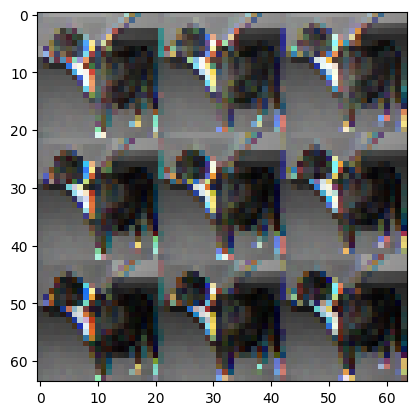

In [17]:
plt.imshow(val[0][5].reshape(64,64,3))

#this is a good model

In [26]:
model = nn.Sequential(
            # Block 1: Input 3 x 128 x 128 (Example size)
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # Output: 32 x 64 x 64

            # Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # Output: 64 x 32 x 32

            # Block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # Output: 128 x 16 x 16

            nn.Flatten(),

            nn.Linear(8192, 512),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(512, 1),
        ).to(device)

model = torch.compile(model)

In [27]:
l_tr = []
l_ts = []

In [28]:
epochs = 3
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


for epoch in tqdm(range(epochs)):
    train_loss = test_loss = acc = pts= 0

    model.train()
    for btch_no, (x_train, y_train) in enumerate(train_loader):
        optimizer.zero_grad()
        y_train_pred = model(x_train.to(device))

        loss = loss_fn(y_train_pred.squeeze(), y_train.to(device).float())
        train_loss += loss

        loss.backward()
        optimizer.step()

    train_loss /= len(train_loader)

    model.eval()
    with torch.inference_mode():
        for x_test, y_test in test_loader:
            y_test_pred = model(x_test.to(device))

            test_loss += loss_fn(y_test_pred.squeeze(), y_test.to(device).float())
            acc += torch.sum(torch.round(y_test_pred.sigmoid().squeeze().to('cpu')) == y_test)
            pts += len(y_test)


        test_loss /= len(test_loader)

    acc = (acc/pts) * 100

    l_tr.append(train_loss.detach().cpu())
    l_ts.append(test_loss.detach().cpu())

    print(f"Epoch: {epoch} | Train loss: {train_loss: .4f} | Test loss: {test_loss: .4f} | Test Accuracy:{acc: .2f}")


  0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
 33%|███▎      | 1/3 [01:02<02:04, 62.15s/it]

Epoch: 0 | Train loss:  1.0593 | Test loss:  0.6410 | Test Accuracy: 62.58


 67%|██████▋   | 2/3 [02:04<01:02, 62.55s/it]

Epoch: 1 | Train loss:  0.6612 | Test loss:  0.6451 | Test Accuracy: 63.62


100%|██████████| 3/3 [03:06<00:00, 62.14s/it]

Epoch: 2 | Train loss:  0.6285 | Test loss:  0.5818 | Test Accuracy: 69.72


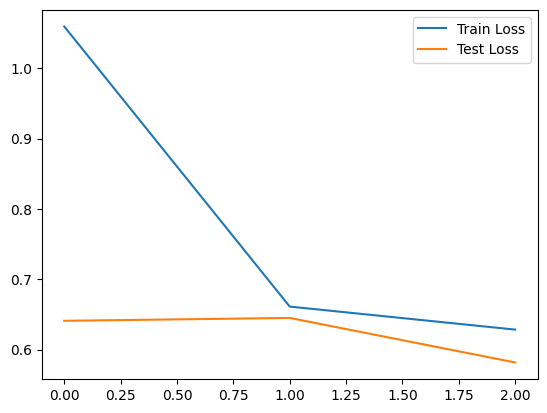

In [29]:
import matplotlib.pyplot as plt

plt.plot(l_tr, label='Train Loss')
plt.plot(l_ts, label='Test Loss')

plt.legend()
plt.show()